## Libraries and settings

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import math
from scipy.stats import ttest_ind
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.neighbors import NearestNeighbors
import scipy

from numpy import mean
from numpy import var
from math import sqrt

sns.set()

pd.set_option('display.max_columns', None)

## Data Generating Process

In [ ]:
def construct_sec_order(arr):
    # an intermediate data generation function used for generating second order information
    second_order_feature = []
    num_cov_sec = len(arr[0])
    for a in arr:
        tmp = []
        for i in range(num_cov_sec):
            for j in range(i+1, num_cov_sec):
                tmp.append( a[i] * a[j] )
        second_order_feature.append(tmp)
    return np.array(second_order_feature)

In [ ]:
def data_generation_dense_endo(num_samples, num_cov_dense, num_covs_unimportant, rho=0, enforce_overlap=True):
    def u(x):
        T = []
        for row in x:
            # Use multiple covariates to determine treatment, normalized
            score = (row[0] + row[1] + row[2]) / 3
            prob = scipy.special.expit(score)  # sigmoid function to smooth probabilities
            if enforce_overlap:
                # Clip probabilities to [0.1, 0.9] to ensure overlap
                prob = np.clip(prob, 0.1, 0.9)
            t = np.random.binomial(1, prob)
            T.append(t)
        return np.array(T)

    mu = np.ones((num_samples, num_cov_dense))
    sigma = (1 - rho) * np.eye(num_cov_dense) + rho * np.ones((num_cov_dense, num_cov_dense))
    x = np.matmul(np.random.normal(0, 0.5, size=(num_samples, num_cov_dense)), sigma) + mu

    errors = np.random.normal(0, 1, size=num_samples)

    dense_bs_sign = np.random.choice([-1, 1], num_cov_dense)
    dense_bs = [dense_bs_sign[i] * 10. * (1. / 2 ** (i + 1)) for i in range(num_cov_dense)]

    treatment_eff_coef = np.random.normal(1.0, 0.5, size=num_cov_dense)
    treatment_effect = np.dot(x, treatment_eff_coef)
    second = construct_sec_order(x[:, :num_cov_dense])
    treatment_eff_sec = np.sum(second, axis=1)

    x2 = np.random.normal(1, 1.5, size=(num_samples, num_covs_unimportant))

    T = u(x)

    y0 = np.dot(x, np.array(dense_bs)) + errors
    y1 = y0 + (treatment_effect + treatment_eff_sec)  # treatment effect added on top of y0
    y = T * y1 + (1 - T) * y0
    te = y1 - y0

    df = pd.DataFrame(np.hstack([x, x2]), columns=['X%d' % j for j in range(num_cov_dense + num_covs_unimportant)])
    df['Y'] = y
    df['T'] = T

    df_true = pd.DataFrame()
    df_true['Y1'] = y1
    df_true['Y0'] = y0
    df_true['TE'] = te

    return df, df_true

In [ ]:
df, df_true = data_generation_dense_endo(num_samples=100000, num_cov_dense=75, num_covs_unimportant=75)

In [ ]:
# Calculate true ATE
true_ate = df_true['TE'].mean()
print("True ATE:", true_ate)

True ATE: 2011.2248584460565


In [ ]:
sns.histplot(df_true['TE'], kde=True)
plt.title("Distribution of True Individual Treatment Effects (ITE)")
plt.xlabel("True Treatment Effect")
plt.ylabel("Frequency")
plt.show()

In [ ]:
df.to_csv('MALTS_DGS_df_n100000_x150.csv', index=False)
df_true.to_csv('MALTS_DGS_df_true_n100000_x150.csv', index=False)

In [ ]:
df = pd.read_csv('MALTS_DGS_df_n10000_x150.csv')
df

,X0,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14,X15,X16,X17,X18,X19,X20,X21,X22,X23,X24,X25,X26,X27,X28,X29,X30,X31,X32,X33,X34,X35,X36,X37,X38,X39,X40,X41,X42,X43,X44,X45,X46,X47,X48,X49,X50,X51,X52,X53,X54,X55,X56,X57,X58,X59,X60,X61,X62,X63,X64,X65,X66,X67,X68,X69,X70,X71,X72,X73,X74,X75,X76,X77,X78,X79,X80,X81,X82,X83,X84,X85,X86,X87,X88,X89,X90,X91,X92,X93,X94,X95,X96,X97,X98,X99,X100,X101,X102,X103,X104,X105,X106,X107,X108,X109,X110,X111,X112,X113,X114,X115,X116,X117,X118,X119,X120,X121,X122,X123,X124,X125,X126,X127,X128,X129,X130,X131,X132,X133,X134,X135,X136,X137,X138,X139,X140,X141,X142,X143,X144,X145,X146,X147,X148,X149,Y,T
0,0.833990,1.305377,0.687040,0.518827,1.399339,0.699902,0.881287,1.135116,0.826732,0.964820,0.730674,0.248830,0.750031,0.892878,0.944591,1.442870,0.802656,2.003533,0.816634,1.042134,0.392819,0.941553,1.434843,0.267415,0.623650,0.523286,1.339517,0.916505,0.416853,0.652104,1.770005,1.193980,1.121710,0.821763,1.134087,0.789469,-0.056839,1.595916,1.352594,0.641996,0.941627,1.222729,1.162852,0.374325,0.814830,0.869180,1.535504,1.294557,1.504172,0.772038,0.741321,1.210190,-0.433510,1.571265,0.951616,0.699564,1.130155,0.770738,1.001760,0.984545,1.844680,0.770471,1.595875,1.533853,0.326072,0.683717,0.899144,0.792879,1.392377,0.735965,0.933281,0.513905,0.723044,1.062397,0.474684,1.187666,0.613837,0.765795,-1.214646,3.720967,-0.519100,3.061463,1.509845,0.175295,2.032018,1.159226,-1.131577,0.020042,3.986362,2.856637,-0.495548,1.546082,-0.447523,-0.696619,2.011433,-0.249337,1.073202,3.608854,1.670599,-0.239355,1.100199,-1.058613,2.397277,0.027237,2.533568,1.620203,2.868498,1.116941,0.324659,-1.470909,1.859523,1.296281,2.856305,2.161115,-0.052812,1.948674,0.793802,3.161406,2.673297,1.226912,0.884181,1.970629,1.781261,0.642095,1.028862,0.829472,-0.711014,1.985146,1.635364,1.687230,1.685232,1.862063,-0.476494,1.140909,1.548903,3.135266,-0.844313,0.794429,0.025827,2.988955,1.105090,1.823248,2.156269,-0.529136,-1.291197,-0.386471,0.711601,4.156831,1.133469,0.993114,2506.590807,1
1,0.416120,1.519554,0.395080,0.908711,1.185237,0.764108,0.603000,0.746802,0.396210,0.904712,2.320265,1.190151,0.173283,1.358817,1.169034,1.573960,1.032106,1.402150,1.360751,0.448917,0.498486,0.919234,0.492880,0.876587,-0.195716,0.822932,0.944411,1.145766,0.483965,-0.199534,0.106241,0.530921,1.094663,1.749787,0.598844,0.966232,1.827717,-0.253044,1.013557,1.171729,0.635417,1.066623,0.767748,1.157455,0.828192,0.558304,0.282309,0.691071,0.962158,1.275775,1.349554,0.962110,1.092851,0.905878,1.714458,1.693135,0.647308,0.889887,2.206551,1.985980,0.379212,0.225821,0.180094,0.715353,1.380790,1.039572,0.726648,1.087731,0.692337,1.235362,1.002592,1.456291,1.515250,1.762797,1.531141,-1.286126,2.550689,0.992453,1.323893,1.718792,-1.089900,-0.483704,2.187076,-0.128027,0.572427,0.616724,1.936448,2.109546,0.798189,2.681896,0.845251,1.569772,1.092337,1.100802,0.219452,2.088297,0.429649,-0.956256,3.657597,0.658303,0.314386,2.470588,1.793459,2.571090,2.459125,-0.079044,3.351915,3.409434,0.533261,0.867000,-1.222087,-0.776853,1.302617,0.653305,0.430450,0.608443,1.703110,-0.472662,-0.194841,0.560155,2.635353,-0.978309,-0.745326,-0.620926,1.942185,-0.857857,-1.218360,-1.401902,0.798992,3.690423,2.223953,3.504800,2.254920,-0.746014,0.027763,-1.091266,-0.173504,1.455002,0.592136,0.950237,1.867737,1.170314,2.388806,1.136627,0.606077,2.261347,3.420615,0.835921,3.543927,-1.754965,2567.860697,1
2,0.441218,1.567093,0.453683,1.069652,1.510786,0.827258,1.522429,1.562405,0.852069,1.040161,1.655107,1.144929,0.988933,0.923444,0.630670,1.667271,1.364790,0.895255,0.791646,1.107589,1.335383,1.027772,1.714673,0.456812,0.765694,0.514743,1.524203,0.922916,1.600876,2.210443,0.992736,0.453136,0.591468,0.314751,1.155101,1.661831,0.406809,1.068086,0.973516,1.355860,1.314098,1.166293,0.542832,1.516216,1.071100,1.403787,1.186410,0.012210,-0.084307,1.720757,0.829191,1.755747,1.402982,1.669095,1.288478,0.237469,0.494656,0.727096,0.462227,-0.058680,-0.076849,0.816202,0.905977,-0.109122

## Matching methods

### V: Propensity score
Source code: https://www.kaggle.com/code/harrywang/propensity-score-matching-in-python

Not a stable library: https://pypi.org/project/psmpy/#predict-scores

Another source: https://towardsdatascience.com/causal-inference-with-python-a-guide-to-propensity-score-matching-b3470080c84f/



In [ ]:
df.groupby('T').mean()

In [ ]:
# separate control and treatment for t-test
df_control = df[df['T']==0]
df_treatment = df[df['T']==1]

In [ ]:
print(df_control.Y.mean(), df_treatment.Y.mean())

# compare samples
_, p = ttest_ind(df_control.Y, df_treatment.Y)
print(f'p={p:.3f}')

# interpret
alpha = 0.05  # significance level
if p > alpha:
    print('same distributions/same group mean (fail to reject H0 - we do not have enough evidence to reject H0)')
else:
    print('different distributions/different group mean (reject H0)')

In [ ]:
X = df[[f'X{i}' for i in range(150)]]

T = df['T']

Y = df['Y']

In [ ]:
X

,X0,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14,X15,X16,X17,X18,X19,X20,X21,X22,X23,X24,X25,X26,X27,X28,X29,X30,X31,X32,X33,X34,X35,X36,X37,X38,X39,X40,X41,X42,X43,X44,X45,X46,X47,X48,X49,X50,X51,X52,X53,X54,X55,X56,X57,X58,X59,X60,X61,X62,X63,X64,X65,X66,X67,X68,X69,X70,X71,X72,X73,X74,X75,X76,X77,X78,X79,X80,X81,X82,X83,X84,X85,X86,X87,X88,X89,X90,X91,X92,X93,X94,X95,X96,X97,X98,X99
0,1.553264,0.981440,1.319695,1.703926,1.085313,1.725645,1.403306,0.695549,1.588277,0.798712,1.711240,1.160630,-0.238618,0.556938,1.209878,0.920739,1.512416,-0.370117,1.679409,0.496145,0.791642,1.397035,1.087886,1.553611,1.075988,1.242403,1.197491,1.598848,1.056572,0.929117,0.904199,-0.003773,0.004855,1.000916,0.829524,0.803687,0.676266,0.674339,1.408040,0.737351,0.673369,1.463774,0.449455,1.565755,2.395663,0.950526,0.682507,0.717452,0.391100,1.671426,0.609243,1.506405,2.447571,-0.221298,1.092334,0.028817,-0.298042,0.479723,0.142348,-0.144540,0.095134,1.566411,-2.028869,-0.104341,1.372264,1.773946,2.791416,2.350725,3.437909,-1.023563,-0.315085,3.238677,-0.859740,-2.285271,1.055814,2.114207,1.043952,1.615284,1.117814,-0.099963,3.429586,-0.737247,1.985028,-1.504895,2.793881,-2.060062,2.691588,1.068243,4.309198,2.921217,-0.687032,-0.252674,-0.240803,0.626939,3.168057,2.046193,0.035749,0.589221,-0.680726,0.747802
1,0.712358,0.898547,0.726579,1.287028,1.789095,0.252710,-0.102189,1.111308,0.980923,1.205716,1.242395,1.122501,0.662274,0.608399,0.857803,0.040088,0.713117,0.643609,0.434914,0.960664,0.910071,1.130588,0.988883,1.958349,1.362243,1.090020,0.971901,1.298396,1.052696,1.152075,1.359003,0.381680,1.585233,1.730855,0.633753,0.303701,1.814901,1.266869,1.263562,0.747254,1.636181,0.828905,0.877634,1.546493,1.754945,0.727011,0.399968,0.528729,2.085959,1.845676,-0.585026,2.174397,0.923443,-0.541208,-0.377873,-0.038117,1.394775,1.233925,-0.035344,2.607407,1.633170,0.084219,1.561833,1.150847,4.389583,0.235565,3.075433,0.836163,-1.605493,-0.764731,0.547198,0.330986,2.358302,0.239170,0.693523,-1.249209,-1.316885,0.737319,2.214973,0.416480,-0.210800,2.572698,3.494616,1.160944,-1.334495,0.108008,-1.408650,1.549409,3.068356,-0.776736,1.211768,3.001835,1.558270,1.399838,-0.643014,-2.695548,2.370701,1.329821,1.906680,2.852326
2,1.794176,1.168063,0.698550,0.880471,1.333262,1.375728,0.851551,0.329436,0.927075,2.073797,1.784655,1.156830,0.944051,0.171673,1.963540,0.641081,1.060312,1.370585,0.742487,0.571594,1.053210,0.409079,0.615276,0.661021,1.511105,1.469724,0.435500,1.088962,0.211066,0.246900,0.868852,-0.038180,2.044631,1.082654,0.894251,0.869981,0.703479,0.402258,2.477267,0.845566,0.637436,0.525425,0.664363,1.174270,1.693821,-0.011542,0.668244,1.988775,1.444368,1.104003,-1.117461,0.784906,2.419664,-0.127153,1.080330,2.567705,1.120088,1.724572,1.564797,0.732928,-0.050757,2.810894,-1.240405,-0.707450,1.300276,1.662569,-1.415555,2.061849,2.105204,0.449547,0.113410,2.270098,0.977307,1.535978,-1.991822,-0.579821,0.449433,1.861934,0.310404,3.679098,-1.028198,1.167499,3.193150,-0.432389,1.645952,0.785407,1.461214,1.124833,-1.087021,-0.741256,2.513333,2.119810,-0.475439,3.737847,-2.589210,0.430928,-0.675674,-0.553067,1.395199,1.482903
3,0.778713,0.241925,1.429765,0.590473,0.968695,0.855857,1.227653,0.935648,1.848918,1.401986,0.294662,1.585192,0.716969,0.271120,0.946201,0.705402,0.681342,1.108679,0.624656,0.866853,2.137493,1.562836,1.356705,0.345111,1.190078,1.935269,0.339266,0.805498,1.802049,1.090500,0.264488,0.851371,1.233998,1.431467,0.887679,0.260259,1.442838,0.292227,0.777171,0.909616,1.475854,0.954892,0.826723,0.708096,0.638829,0.852107,0.866208,1.240112,0.258774,0.803740,1.441696,2.182247,2.750490,1.954602,3.062093,-1.348462,1.924020,0.652808,1.677305,-0.936635,1.590758,-0.054389,-0.111750,1.462498,-2.473975,2.297055,-2.645077,5.023255,4.767049,-0.775197,0.007118,-1.042408,0.669692,1.313611,-1.485068,0.851267,0.819023,2.412915,1.351522,2.330978,2.926948,-0.205825,3.593515,0.717109,1.323009,3.375095,1.872720,2.154962,1.747691,0.124825,1.044637,0.593941,-2.284852

##### Start runtime

In [ ]:
import time

start_time = time.perf_counter()

In [ ]:
# use logistic regression to calculate the propensity scores
lr = LogisticRegression(max_iter=1000, solver='liblinear')
lr.fit(X, T)

LogisticRegression(max_iter=1000, solver='liblinear')

In [ ]:
# prediction
pred_binary = lr.predict(X)  # binary 0 control, 1, treatment
pred_prob = lr.predict_proba(X)  # probabilities for classes

#print('the binary prediction is:', pred_binary[0])
#print('the corresponding probabilities are:', pred_prob[0])

In [ ]:
df['ps'] = pred_prob[:, 1] # the propensity score (ps) is the probability of being 1 (i.e., in the treatment group)
#matching_df_new = matching_df[(matching_df['ps'] < 0.99) | (matching_df['ps'] < 0.01)]

In [ ]:
# Assuming matching_df is your DataFrame
caliper = np.std(df['ps']) * 0.25
print(f'caliper (radius) is: {caliper:.4f}')

n_neighbors = 10

# Setup the knn model
knn = NearestNeighbors(n_neighbors=n_neighbors, radius=caliper)

# Reshape the 'ps' column to be 2D
ps = df['ps'].values.reshape(-1, 1)  # Reshape to (n_samples, 1)

# Fit the model
knn.fit(ps)

caliper (radius) is: 0.0358


NearestNeighbors(n_neighbors=10, radius=0.03584179427643803)

In [ ]:
# distances and indexes
distances, neighbor_indexes = knn.kneighbors(ps)

#print(neighbor_indexes.shape)

# the 10 closest points to the first point
#print(distances[0])
#print(neighbor_indexes[0])

In [ ]:
# for each point in treatment, we find a matching point in control without replacement
# note the 10 neighbors may include both points in treatment and control

matched_control = []  # keep track of the matched observations in control

for current_index, row in df.iterrows():  # iterate over the dataframe
    if row['T'] == 0:  # the current row is in the control group
        df.loc[current_index, 'matched'] = np.nan  # set matched to nan
    else:
        for idx in neighbor_indexes[current_index, :]: # for each row in treatment, find the k neighbors
            # make sure the current row is not the idx - don't match to itself
            # and the neighbor is in the control
            if (current_index != idx) and (df.loc[idx, 'T'] == 0):
                if idx not in matched_control:  # this control has not been matched yet
                    df.loc[current_index, 'matched'] = idx  # record the matching
                    matched_control.append(idx)  # add the matched to the list
                    break

In [ ]:
# control have no match
treatment_matched = df.dropna(subset=['matched'])  # drop not matched

# matched control observation indexes
control_matched_idx = treatment_matched.matched
control_matched_idx = control_matched_idx.astype(int)  # change to int
control_matched = df.loc[control_matched_idx, :]  # select matched control observations

# combine the matched treatment and control
df_matched = pd.concat([treatment_matched, control_matched])

#df_matched['T'].value_counts()

In [ ]:
# matched control and treatment
df_matched_control = df_matched[df_matched['T']==0]
df_matched_treatment = df_matched[df_matched['T']==1]

In [ ]:
for _ in range(1000000):
    pass

end_time = time.perf_counter()

execution_time = end_time - start_time

print(f"The code took {execution_time} seconds to run.")

The code took 26.27558412899998 seconds to run.


##### End runtime and find ATE

In [ ]:
ATE = df_matched_treatment['Y'].mean() - df_matched_control['Y'].mean()
print(f"Average Treatment Effect (ATE): {ATE}")

Average Treatment Effect (ATE): 1253.4975880191785


In [ ]:
def logit(p):
    logit_value = math.log(p / (1-p))
    return logit_value

df['ps_logit'] = df.ps.apply(lambda x: logit(x))

#df.head()

In [ ]:
# get the coefficients
lr.coef_.ravel()  # or reshape(-1) refers to an unknown dimension, often used to flatten the array

# get the feature names
X.columns.to_numpy()

# combine features and coefficients into a dataframe
coeffs = pd.DataFrame({
    'column':X.columns.to_numpy(),
    'coeff':lr.coef_.ravel(),
})
#coeffs

In [ ]:
# student's t-test for revenue (dependent variable) after matching
# p value is not significant now
print(df_matched_control['Y'].mean(), df_matched_treatment['Y'].mean())

# compare samples
_, p = ttest_ind(df_matched_control['Y'], df_matched_treatment['Y'])
print(f'p={p:.3f}')

# interpret
alpha = 0.05  # significance level
if p > alpha:
    print('same distributions/same group mean (fail to reject H0 - we do not have enough evidence to reject H0)')
else:
    print('different distributions/different group mean (reject H0)')

8.723729754519352 2814.4370698710395
p=0.000
different distributions/different group mean (reject H0)


In [ ]:
# try to increase the number of neighbors and/or caliper to get more matches
print('total observations in treatment:', len(df[df['T']==1]))
print('total matched observations in control:', len(matched_control))

total observations in treatment: 712
total matched observations in control: 223


<Axes: xlabel='ps', ylabel='Count'>

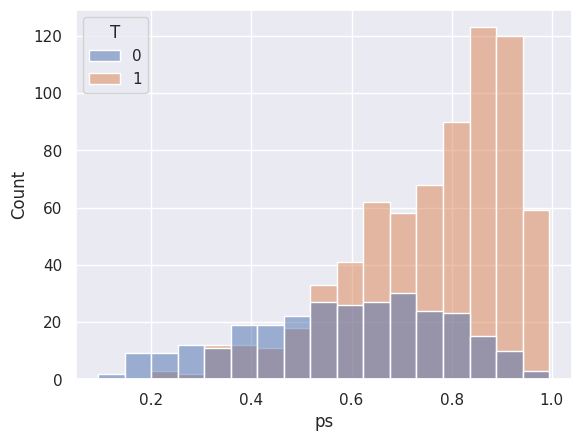

In [ ]:
# check the overlap of ps for control and treatment using histogram
# if not much overlap, the matching won't work
sns.histplot(data=df, x='ps', hue='T')  # multiple="dodge" for

### V: MALTS

* is this using the generalized Mahamlanobis distance for continuous data?

In [ ]:
import scipy.optimize as opt
import sklearn.linear_model as lm
import sklearn.ensemble as ensemble
import sklearn.gaussian_process as gp
from sklearn.gaussian_process.kernels import RBF, WhiteKernel
import matplotlib.patches as patches
from sklearn.model_selection import RepeatedStratifiedKFold
import warnings
warnings.filterwarnings("ignore")

In [ ]:
#cols = ['X0','X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9', 'X10', 'X11', 'X12', 'X13', 'X14', 'X15', 'X16', 'X17', 'X18', 'X19', 'X20', 'X21', 'X22', 'X23', 'X24', 'X25', 'X26', 'X27', 'X28', 'X29', 'X30', 'X31', 'X32', 'X33', 'X34', 'X35', 'X36', 'X37', 'X38', 'X39', 'X40', 'X41', 'X42', 'X43', 'X44', 'X45', 'X46', 'X47', 'X48', 'X49', 'X50', 'X51', 'X52', 'X53', 'X54', 'X55', 'X56', 'X57', 'X58', 'X59', 'X60', 'X61', 'X62', 'X63', 'X64', 'X65', 'X66', 'X67', 'X68', 'X69', 'X70', 'X71', 'X72', 'X73', 'X74', 'X75', 'X76', 'X77', 'X78', 'X79', 'X80', 'X81', 'X82', 'X83', 'X84', 'X85', 'X86', 'X87', 'X88', 'X89', 'X90', 'X91', 'X92', 'X93', 'X94', 'X95', 'X96', 'X97', 'X98', 'X99', 'X100', 'X101', 'X102', 'X103', 'X104', 'X105', 'X106', 'X107', 'X108', 'X109', 'X110', 'X111', 'X112', 'X113', 'X114', 'X115', 'X116', 'X117', 'X118', 'X119', 'X120', 'X121', 'X122', 'X123', 'X124', 'X125', 'X126', 'X127', 'X128', 'X129', 'X130', 'X131', 'X132', 'X133', 'X134', 'X135', 'X136', 'X137', 'X138', 'X139', 'X140', 'X141', 'X142', 'X143', 'X144', 'X145', 'X146', 'X147', 'X148', 'X149','Y','T']
cols = [f'X{i}' for i in range(150)] + ['Y', 'T']


In [ ]:
cols

['X0',
 'X1',
 'X2',
 'X3',
 'X4',
 'X5',
 'X6',
 'X7',
 'X8',
 'X9',
 'X10',
 'X11',
 'X12',
 'X13',
 'X14',
 'X15',
 'X16',
 'X17',
 'X18',
 'X19',
 'X20',
 'X21',
 'X22',
 'X23',
 'X24',
 'X25',
 'X26',
 'X27',
 'X28',
 'X29',
 'X30',
 'X31',
 'X32',
 'X33',
 'X34',
 'X35',
 'X36',
 'X37',
 'X38',
 'X39',
 'X40',
 'X41',
 'X42',
 'X43',
 'X44',
 'X45',
 'X46',
 'X47',
 'X48',
 'X49',
 'X50',
 'X51',
 'X52',
 'X53',
 'X54',
 'X55',
 'X56',
 'X57',
 'X58',
 'X59',
 'X60',
 'X61',
 'X62',
 'X63',
 'X64',
 'X65',
 'X66',
 'X67',
 'X68',
 'X69',
 'X70',
 'X71',
 'X72',
 'X73',
 'X74',
 'X75',
 'X76',
 'X77',
 'X78',
 'X79',
 'X80',
 'X81',
 'X82',
 'X83',
 'X84',
 'X85',
 'X86',
 'X87',
 'X88',
 'X89',
 'X90',
 'X91',
 'X92',
 'X93',
 'X94',
 'X95',
 'X96',
 'X97',
 'X98',
 'X99',
 'X100',
 'X101',
 'X102',
 'X103',
 'X104',
 'X105',
 'X106',
 'X107',
 'X108',
 'X109',
 'X110',
 'X111',
 'X112',
 'X113',
 'X114',
 'X115',
 'X116',
 'X117',
 'X118',
 'X119',
 'X120',
 'X121',
 'X122',
 'X

##### Start runtime

In [ ]:
import time

start_time = time.perf_counter()

In [ ]:
class malts:
    def __init__(self,outcome,treatment,data,discrete=[],C=1,k=10,reweight=False):
        # np.random.seed(0)
        self.C = C #coefficient to regularozation term
        self.k = k
        self.reweight = reweight
        self.n, self.p = data.shape
        self.p = self.p - 2 #shape of the data
        self.outcome = outcome
        self.treatment = treatment
        self.discrete = discrete
        self.continuous = list(set(data.columns).difference(set([outcome]+[treatment]+discrete)))
        #splitting the data into control and treated units
        self.df_T = data.loc[data[treatment]==1]
        self.df_C = data.loc[data[treatment]==0]
        #extracting relevant covariates (discrete,continuous)
        #and outcome. Converting to numpy array.
        self.Xc_T = self.df_T[self.continuous].to_numpy()
        self.Xc_C = self.df_C[self.continuous].to_numpy()
        self.Xd_T = self.df_T[self.discrete].to_numpy()
        self.Xd_C = self.df_C[self.discrete].to_numpy()
        self.Y_T = self.df_T[self.outcome].to_numpy()
        self.Y_C = self.df_C[self.outcome].to_numpy()
        self.del2_Y_T = ((np.ones((len(self.Y_T),len(self.Y_T)))*self.Y_T).T - (np.ones((len(self.Y_T),len(self.Y_T)))*self.Y_T))**2
        self.del2_Y_C = ((np.ones((len(self.Y_C),len(self.Y_C)))*self.Y_C).T - (np.ones((len(self.Y_C),len(self.Y_C)))*self.Y_C))**2

        self.Dc_T = np.ones((self.Xc_T.shape[0],self.Xc_T.shape[1],self.Xc_T.shape[0])) * self.Xc_T.T
        self.Dc_T = (self.Dc_T - self.Dc_T.T)
        self.Dc_C = np.ones((self.Xc_C.shape[0],self.Xc_C.shape[1],self.Xc_C.shape[0])) * self.Xc_C.T
        self.Dc_C = (self.Dc_C - self.Dc_C.T)

        self.Dd_T = np.ones((self.Xd_T.shape[0],self.Xd_T.shape[1],self.Xd_T.shape[0])) * self.Xd_T.T
        self.Dd_T = (self.Dd_T != self.Dd_T.T)
        self.Dd_C = np.ones((self.Xd_C.shape[0],self.Xd_C.shape[1],self.Xd_C.shape[0])) * self.Xd_C.T
        self.Dd_C = (self.Dd_C != self.Dd_C.T)

    def threshold(self,x):
        k = self.k
        for i in range(x.shape[0]):
            row = x[i,:]
            row1 = np.where( row < row[np.argpartition(row,k+1)[k+1]],1,0)
            x[i,:] = row1
        return x

    def distance(self,Mc,Md,xc1,xd1,xc2,xd2):
        dc = np.dot((Mc**2)*(xc1-xc2),(xc1-xc2))
        dd = np.sum((Md**2)*xd1!=xd2)
        return dc+dd

    def loss_(self, Mc, Md, xc1, xd1, y1, xc2, xd2, y2, gamma=1 ):
        w12 = np.exp( -1 * gamma * self.distance(Mc,Md,xc1,xd1,xc2,xd2) )
        return w12*((y1-y2)**2)

    def calcW_T(self,Mc,Md):
        #this step is slow
        Dc = np.sum( ( self.Dc_T * (Mc.reshape(-1,1)) )**2, axis=1)
        Dd = np.sum( ( self.Dd_T * (Md.reshape(-1,1)) )**2, axis=1)
        W = self.threshold( (Dc + Dd) )
        W = W / (np.sum(W,axis=1)-np.diag(W)).reshape(-1,1)
        return W

    def calcW_C(self,Mc,Md):
        #this step is slow
        Dc = np.sum( ( self.Dc_C * (Mc.reshape(-1,1)) )**2, axis=1)
        Dd = np.sum( ( self.Dd_C * (Md.reshape(-1,1)) )**2, axis=1)
        W = self.threshold( (Dc + Dd) )
        W = W / (np.sum(W,axis=1)-np.diag(W)).reshape(-1,1)
        return W

    def Delta_(self,Mc,Md):
        self.W_T = self.calcW_T(Mc,Md)
        self.W_C = self.calcW_C(Mc,Md)
        self.delta_T = np.sum((self.Y_T - (np.matmul(self.W_T,self.Y_T) - np.diag(self.W_T)*self.Y_T))**2)
        self.delta_C = np.sum((self.Y_C - (np.matmul(self.W_C,self.Y_C) - np.diag(self.W_C)*self.Y_C))**2)
        if self.reweight == False:
            return self.delta_T + self.delta_C
        elif self.reweight == True:
            return (len(self.Y_T)+len(self.Y_C))*(self.delta_T/len(self.Y_T) + self.delta_C/len(self.Y_C))

    def objective(self,M):
        Mc = M[:len(self.continuous)]
        Md = M[len(self.continuous):]
        delta = self.Delta_(Mc,Md)
        reg = self.C * ( np.linalg.norm(Mc,ord=2)**2 + np.linalg.norm(Md,ord=2)**2 )
        cons1 = 0 * ( (np.sum(Mc) + np.sum(Md)) - self.p )**2
        cons2 = 1e+25 * np.sum( ( np.concatenate((Mc,Md)) < 0 ) )
        return delta + reg + cons1 + cons2

    def fit(self,method='COBYLA'):
        # np.random.seed(0)
        M_init = np.ones((self.p,))
        res = opt.minimize( self.objective, x0=M_init,method=method )
        self.M = res.x
        self.Mc = self.M[:len(self.continuous)]
        self.Md = self.M[len(self.continuous):]
        self.M_opt = pd.DataFrame(self.M.reshape(1,-1),columns=self.continuous+self.discrete,index=['Diag'])
        return res

    def get_matched_groups(self, df_estimation, k=10 ):
        #units to be matched
        Xc = df_estimation[self.continuous].to_numpy()
        Xd = df_estimation[self.discrete].to_numpy()
        Y = df_estimation[self.outcome].to_numpy()
        T = df_estimation[self.treatment].to_numpy()
        #splitted estimation data for matching
        df_T = df_estimation.loc[df_estimation[self.treatment]==1]
        df_C = df_estimation.loc[df_estimation[self.treatment]==0]
        #converting to numpy array
        Xc_T = df_T[self.continuous].to_numpy()
        Xc_C = df_C[self.continuous].to_numpy()
        Xd_T = df_T[self.discrete].to_numpy()
        Xd_C = df_C[self.discrete].to_numpy()
        Y_T = df_T[self.outcome].to_numpy()
        Y_C = df_C[self.outcome].to_numpy()
        D_T = np.zeros((Y.shape[0],Y_T.shape[0]))
        D_C = np.zeros((Y.shape[0],Y_C.shape[0]))
        #distance_treated
        Dc_T = (np.ones((Xc_T.shape[0],Xc.shape[1],Xc.shape[0])) * Xc.T - (np.ones((Xc.shape[0],Xc.shape[1],Xc_T.shape[0])) * Xc_T.T).T)
        Dc_T = np.sum( (Dc_T * (self.Mc.reshape(-1,1)) )**2 , axis=1 )
        Dd_T = (np.ones((Xd_T.shape[0],Xd.shape[1],Xd.shape[0])) * Xd.T != (np.ones((Xd.shape[0],Xd.shape[1],Xd_T.shape[0])) * Xd_T.T).T )
        Dd_T = np.sum( (Dd_T * (self.Md.reshape(-1,1)) )**2 , axis=1 )
        D_T = (Dc_T + Dd_T).T
        #distance_control
        Dc_C = (np.ones((Xc_C.shape[0],Xc.shape[1],Xc.shape[0])) * Xc.T - (np.ones((Xc.shape[0],Xc.shape[1],Xc_C.shape[0])) * Xc_C.T).T)
        Dc_C = np.sum( (Dc_C * (self.Mc.reshape(-1,1)) )**2 , axis=1 )
        Dd_C = (np.ones((Xd_C.shape[0],Xd.shape[1],Xd.shape[0])) * Xd.T != (np.ones((Xd.shape[0],Xd.shape[1],Xd_C.shape[0])) * Xd_C.T).T )
        Dd_C = np.sum( (Dd_C * (self.Md.reshape(-1,1)) )**2 , axis=1 )
        D_C = (Dc_C + Dd_C).T
        MG = {}
        index = df_estimation.index
        for i in range(Y.shape[0]):
            #finding k closest control units to unit i
            idx = np.argpartition(D_C[i,:],k)
            matched_df_C = pd.DataFrame( np.hstack( (Xc_C[idx[:k],:], Xd_C[idx[:k],:].reshape((k,len(self.discrete))), Y_C[idx[:k]].reshape(-1,1), D_C[i,idx[:k]].reshape(-1,1), np.zeros((k,1)) ) ), index=list(df_C.index[idx[:k]]), columns=self.continuous+self.discrete+[self.outcome,'distance',self.treatment] )
            #finding k closest treated units to unit i
            idx = np.argpartition(D_T[i,:],k)
            matched_df_T = pd.DataFrame( np.hstack( (Xc_T[idx[:k],:], Xd_T[idx[:k],:].reshape((k,len(self.discrete))), Y_T[idx[:k]].reshape(-1,1), D_T[i,idx[:k]].reshape(-1,1), np.ones((k,1)) ) ), index=list(df_T.index[idx[:k]]), columns=self.continuous+self.discrete+[self.outcome,'distance',self.treatment] )
            matched_df_2 = pd.DataFrame(np.hstack((Xc[i], Xd[i], Y[i], 0, T[i])).reshape(1,-1), index=list([-1]), columns=self.continuous+self.discrete+[self.outcome,'distance',self.treatment])
            matched_df =  pd.concat([matched_df_2, matched_df_T, matched_df_C], axis=0)
            MG[index[i]] = matched_df
            #{'unit':[ Xc[i], Xd[i], Y[i], T[i] ] ,'control':[ matched_Xc_C, matched_Xd_C, matched_Y_C, d_array_C],'treated':[matched_Xc_T, matched_Xd_T, matched_Y_T, d_array_T ]}
        MG_df = pd.concat(MG)
        return MG_df

    def CATE(self,MG,outcome_discrete=False,model='linear'):
        print("📌 Entered modified CATE()")
        cate = {}
        for k in pd.unique(MG.index.get_level_values(0)):
            v = MG.loc[k]
            #control
            matched_X_C = v.loc[v[self.treatment]==0].drop(index=-1,errors='ignore')[self.continuous+self.discrete]
            matched_Y_C = v.loc[v[self.treatment]==0].drop(index=-1,errors='ignore')[self.outcome]
            #treated
            matched_X_T = v.loc[v[self.treatment]==1].drop(index=-1,errors='ignore')[self.continuous+self.discrete]
            matched_Y_T = v.loc[v[self.treatment]==1].drop(index=-1,errors='ignore')[self.outcome]
            x = v.loc[-1][self.continuous+self.discrete].to_numpy().reshape(1,-1)

            vc = v[self.continuous].to_numpy()
            vd = v[self.discrete].to_numpy()
            dvc = np.ones((vc.shape[0],vc.shape[1],vc.shape[0])) * vc.T
            dist_cont = np.sum( ( (dvc - dvc.T) * (self.Mc.reshape(-1,1)) )**2, axis=1)
            dvd = np.ones((vd.shape[0],vd.shape[1],vd.shape[0])) * vd.T
            dist_dis = np.sum( ( (dvd - dvd.T) * (self.Md.reshape(-1,1)) )**2, axis=1)
            dist_mat = dist_cont + dist_dis
            diameter = np.max(dist_mat)

            if not outcome_discrete:
                try:
                    if model=='mean':
                        yt = np.mean(matched_Y_T)
                        yc = np.mean(matched_Y_C)
                        cate[k] = {'CATE': yt - yc,'outcome':v.loc[-1][self.outcome],'treatment':v.loc[-1][self.treatment],'diameter':diameter }
                    if model=='linear':
                        yc = lm.Ridge().fit( X = matched_X_C, y = matched_Y_C )
                        yt = lm.Ridge().fit( X = matched_X_T, y = matched_Y_T )
                        cate[k] = {'CATE': yt.predict(x)[0] - yc.predict(x)[0], 'outcome':v.loc[-1][self.outcome],'treatment':v.loc[-1][self.treatment],'diameter':diameter }
                    if model=='RF':
                        yc = ensemble.RandomForestRegressor().fit( X = matched_X_C, y = matched_Y_C )
                        yt = ensemble.RandomForestRegressor().fit( X = matched_X_T, y = matched_Y_T )
                        cate[k] = {'CATE': yt.predict(x)[0] - yc.predict(x)[0], 'outcome':v.loc[-1][self.outcome],'treatment':v.loc[-1][self.treatment],'diameter':diameter }
                except Exception as e:
                  print(f"\n⚠️ Error for unit {k}: {e}")
                  print(f"  → matched_X_C shape: {matched_X_C.shape}, matched_Y_C shape: {matched_Y_C.shape}")
                  print(f"  → matched_X_T shape: {matched_X_T.shape}, matched_Y_T shape: {matched_Y_T.shape}")
                  print(f"  → v.loc[-1]:\n{v.loc[-1]}")
                  cate[k] = {'CATE': np.nan, 'outcome': v.loc[-1][self.outcome],'treatment': v.loc[-1][self.treatment], 'diameter': diameter}
        return pd.DataFrame.from_dict(cate,orient='index')

    def visualizeMG(self,MG,a):
        MGi = MG.loc[a]
        k = int( (MGi.shape[0] - 1 )/2 )
        df = MGi[self.continuous+self.discrete].drop(index=-1)

        df.index.names = ['Unit']
        df.columns.names = ['Covariate']
        tidy = df.stack().to_frame().reset_index().rename(columns={0: 'Covariate Value'})

        T = np.array([0 for i in range(0,k*self.p)] + [1 for i in range(0,k*self.p)])
        tidy[self.treatment] = T

        y0 = np.ones((self.p,k)) * MGi.loc[MGi[self.treatment]==0][self.outcome].drop(index=-1,errors='ignore').to_numpy()
        y0 = y0.flatten('F')
        y1 = np.ones((self.p,k)) * MGi.loc[MGi[self.treatment]==1][self.outcome].drop(index=-1,errors='ignore').to_numpy()
        y1 = y0.flatten('F')
        tidy[self.outcome] = np.hstack( (y0,y1) )
        fig = plt.figure()
        sns.lmplot(sharey=False,sharex=False,x='Covariate Value',y=self.outcome,hue=self.treatment, col='Covariate', data=tidy, col_wrap=3, height=4)
        fig.savefig('matched_group_%d.png'%(a))

        fig = plt.figure(figsize=(15,20))
        pd.plotting.parallel_coordinates(df,self.treatment,colormap=plt.cm.Set1)
        fig.savefig('parallel_coordinate_matched_group_%d.png'%(a))

        return tidy

    def visualizeDimension(self,MG,x1,x2):
        X = []
        fig,ax = plt.subplots(1)
        for k,MGi in MG.items():
            x = np.hstack( (MGi['unit'][0],MGi['unit'][0]) )[ [ x1, x2 ] ]
            X.append(x)
            Xc = np.vstack( (MGi['control'][0],MGi['treated'][0]) )
            Xd = np.vstack( (MGi['control'][1],MGi['treated'][1]) )
            Xm = np.hstack((Xc,Xd))[:,[x1,x2]]
            x1min,x1max = np.min(Xm[:,0]), np.max(Xm[:,0])
            x2min,x2max = np.min(Xm[:,1]), np.max(Xm[:,1])
            rect = patches.Rectangle(x-np.array([(x1max-x1min)/2,(x2max-x2min)/2]),width=x1max-x1min,height=x2max-x2min,linewidth=1,edgecolor='r',facecolor='grey',alpha=0.06)
            ax.add_patch(rect)
        X = np.array(X)
        plt.scatter(X[:,0],X[:,1])
        fig.savefig('marginal_%d_%d_matched_groups.png')
        return X


class malts_mf:
    def __init__(self,outcome,treatment,data,discrete=[], C=1, k_tr=15, k_est=50, estimator='linear', smooth_cate=True, reweight=False,n_splits=5,n_repeats=1,output_format='brief'):
        self.n_splits = n_splits
        self.C = C
        self.k_tr = k_tr
        self.k_est = k_est
        self.outcome = outcome
        self.treatment = treatment
        self.discrete = discrete
        self.continuous = list(set(data.columns).difference(set([outcome]+[treatment]+discrete)))
        self.reweight = reweight

        skf = RepeatedStratifiedKFold(n_splits=n_splits,n_repeats=n_repeats,random_state=0)
        gen_skf = skf.split(data,data[treatment])
        self.M_opt_list = []
        self.MG_list = []
        self.CATE_df = pd.DataFrame()
        N = np.zeros((data.shape[0],data.shape[0]))
        self.MG_matrix = pd.DataFrame(N, columns=data.index, index=data.index)

        i = 0
        for est_idx, train_idx in gen_skf:
            df_train = data.iloc[train_idx]
            df_est = data.iloc[est_idx]
            m = malts( outcome, treatment, data=df_train, discrete=discrete, C=self.C, k=self.k_tr, reweight=self.reweight )
            m.fit()
            self.M_opt_list.append(m.M_opt)
            mg = m.get_matched_groups(df_est,k_est)
            self.MG_list.append(mg)
            self.CATE_df = pd.concat([self.CATE_df, m.CATE(mg,model=estimator)], join='outer', axis=1)

        for i in range(n_splits*n_repeats):
            mg_i = self.MG_list[i]
            for a in mg_i.index:
                if a[1]!=-1:
                    self.MG_matrix.loc[a[0],a[1]] = self.MG_matrix.loc[a[0],a[1]]+1

        cate_df = self.CATE_df['CATE']
        cate_df['avg.CATE'] = cate_df.mean(axis=1)
        cate_df['std.CATE'] = cate_df.std(axis=1)
        cate_df[self.outcome] = self.CATE_df['outcome'].mean(axis=1)
        cate_df[self.treatment] = self.CATE_df['treatment'].mean(axis=1)
        cate_df['avg.Diameter'] = self.CATE_df['diameter'].mean(axis=1)

        LOWER_ALPHA = 0.05
        UPPER_ALPHA = 0.95
        # Each model has to be separate
        lower_model = ensemble.GradientBoostingRegressor(loss='quantile',alpha=LOWER_ALPHA)
        # The mid model will use the default loss
        mid_model = ensemble.GradientBoostingRegressor(loss="ls")
        upper_model = ensemble.GradientBoostingRegressor(loss="quantile",alpha=UPPER_ALPHA)

        try:
            lower_model.fit(data[self.continuous+self.discrete], cate_df['avg.CATE'])
            mid_model.fit(data[self.continuous+self.discrete], cate_df['avg.CATE'])
            upper_model.fit(data[self.continuous+self.discrete], cate_df['avg.CATE'])

            cate_df['std.gbr.CATE'] = np.abs(upper_model.predict(data[self.continuous+self.discrete]) - lower_model.predict(data[self.continuous+self.discrete]))/4
            cate_df['avg.gbr.CATE'] = mid_model.predict(data[self.continuous+self.discrete])

            # kernel = 1.0 * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e3)) + WhiteKernel(noise_level=0.1, noise_level_bounds=(1e-10, np.std(cate_df['avg.CATE'])))
            # gaussian_model = gp.GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=100,normalize_y=True)
            # gaussian_model.fit(data[self.continuous+self.discrete], cate_df['avg.CATE'])
            # gp_pred = gaussian_model.predict(data[self.continuous+self.discrete], return_std=True)
            # cate_df['std.gp.CATE'] = gp_pred[1]
            # cate_df['avg.gp.CATE'] = gp_pred[0]

            # bayes_ridge = lm.BayesianRidge(fit_intercept=True)
            # bayes_ridge.fit(data[self.continuous+self.discrete], cate_df['avg.CATE'])
            # br_pred = bayes_ridge.predict(data[self.continuous+self.discrete], return_std=True)
            # cate_df['std.br.CATE'] = br_pred[1]
            # cate_df['avg.br.CATE'] = br_pred[0]

            if smooth_cate:
                cate_df['avg.CATE'] = cate_df['avg.gbr.CATE']
            cate_df['std.CATE'] = cate_df['std.gbr.CATE']

            if output_format=='brief':
                self.CATE_df = cate_df[['avg.CATE','std.CATE',outcome,treatment]]
            if output_format=='full':
                self.CATE_df = cate_df
        except:
            self.CATE_df = cate_df

In [ ]:
m = malts_mf(outcome='Y', treatment='T', data=df[cols])

📌 Entered modified CATE()
📌 Entered modified CATE()
📌 Entered modified CATE()
📌 Entered modified CATE()
📌 Entered modified CATE()


##### End runtime and find ATE

In [ ]:
for _ in range(1000000):
    pass

end_time = time.perf_counter()

execution_time = end_time - start_time

print(f"The code took {execution_time} seconds to run.")

The code took 323.6832221190016 seconds to run.


In [ ]:
m.CATE_df

,CATE,CATE,CATE,CATE,CATE,avg.CATE,std.CATE,Y,T,avg.Diameter
0,2460.555461,2460.257438,NaN,2462.418938,2463.341104,2461.643235,1.283371,2465.510409,1.0,602.087041
1,2811.775974,3231.044173,2665.305224,NaN,3121.565021,2957.422598,228.230695,10.639075,0.0,620.796259
3,2792.025531,NaN,2787.972540,2789.671107,2785.033676,2788.675713,2.548086,2797.171633,1.0,575.933032
5,2796.978908,NaN,2648.161030,2663.096073,2725.129638,2708.341412,58.752169,5.864464,0.0,565.310245
6,2988.295774,3075.713186,3035.493015,NaN,2719.405174,2954.726788,139.341335,6.298414,0.0,618.187027
...,...,...,...,...,...,...,...,...,...,...
975,NaN,2937.375809,2936.564738,2938.587866,2938.910919,2937.859833,0.941590,2944.319675,1.0,591.391057
981,NaN,3010.333231,3016.438352,3015.036575,3009.444298,3012.813114,2.982653,3023.067878,1.0,652.246505
982,NaN,3080.108390,2821.051730,2449.989249,2789.382797,2785.133042,223.964300,10.042738,0.0,615.138528
989,NaN,3249.712207,3257.812472,3251.374584,3259.090271,3254.497384,4.022879,3263.409009,1.0,582.595506


In [ ]:
ATE = m.CATE_df['avg.CATE'].mean()
ATE

2854.0873314830505

### N: Lasso Coefficient Matching

Reference : https://github.com/almost-matching-exactly/variable_imp_matching/tree/main/Experiments

Paper : https://arxiv.org/pdf/2302.11715

Lasso Coefficient Matching using Synthetic data

In [ ]:
from sklearn.linear_model import Lasso
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [ ]:
#runtime
import time
start_time = time.perf_counter()

In [ ]:

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


X_treated = X_scaled[T == 1]
Y_treated = Y[T == 1]
X_control = X_scaled[T == 0]
Y_control = Y[T == 0]


lasso_treated = Lasso(alpha=0.01)
lasso_treated.fit(X_treated, Y_treated)

lasso_control = Lasso(alpha=0.01)
lasso_control.fit(X_control, Y_control)


coef_treated = np.abs(lasso_treated.coef_) / np.sum(np.abs(lasso_treated.coef_))
coef_control = np.abs(lasso_control.coef_) / np.sum(np.abs(lasso_control.coef_))
feature_weights = (coef_treated + coef_control) / 2


from sklearn.neighbors import NearestNeighbors


X_weighted = X_scaled * feature_weights


n_neighbors = 10
knn = NearestNeighbors(n_neighbors=n_neighbors, metric='manhattan')
knn.fit(X_weighted[T == 0])

distances, neighbor_indexes = knn.kneighbors(X_weighted[T == 1])



In [ ]:
for _ in range(1000000):
    pass

end_time = time.perf_counter()

execution_time = end_time - start_time

print(f"The code took {execution_time} seconds to run.")

The code took 4.396380847999353 seconds to run.


In [ ]:
Y_control = Y[T == 0].reset_index(drop=True)
Y_treated = Y[T == 1].reset_index(drop=True)

control_outcomes = Y_control.iloc[neighbor_indexes.flatten()]


ATE_estimated = np.mean(Y_treated - control_outcomes)

print(f"Estimated ATE using Lasso Coefficient Matching: {ATE_estimated}")


Estimated ATE using Lasso Coefficient Matching: 2859.2991288397357


In [ ]:
df.head()

In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

lasso = Lasso(alpha=0.01)
lasso.fit(X_scaled, T)

propensity_scores = lasso.predict(X_scaled)
df['ps_lcm'] = propensity_scores

weights = np.where(T == 1, 1 / propensity_scores, 1 / (1 - propensity_scores))
df['weights'] = weights


In [ ]:
n_neighbors = 10

knn = NearestNeighbors(n_neighbors=n_neighbors, metric = 'manhattan')
ps = propensity_scores.reshape(-1, 1)
knn.fit(ps)

distances, neighbor_indexes = knn.kneighbors(ps)

In [ ]:
matched_control = []
for current_index, row in enumerate(df.itertuples()):
    if row.T == 1:
        matched = False
        for idx in neighbor_indexes[current_index, :]:
            if df.loc[idx, 'T'] == 0 and idx not in matched_control:
                df.loc[current_index, 'matched'] = idx
                matched_control.append(idx)
                matched = True
                break
        if not matched:
            df.loc[current_index, 'matched'] = np.nan

In [ ]:
treatment_matched = df.dropna(subset=['matched'])
control_matched_idx = treatment_matched['matched'].astype(int)
control_matched = df.loc[control_matched_idx, :]

In [ ]:
df_matched = pd.concat([treatment_matched, control_matched])

In [ ]:
weighted_treatment_outcome = np.sum(df_matched[df_matched['T'] == 1]['weights'] * df_matched[df_matched['T'] == 1]['Y']) / np.sum(df_matched[df_matched['T'] == 1]['weights'])
weighted_control_outcome = np.sum(df_matched[df_matched['T'] == 0]['weights'] * df_matched[df_matched['T'] == 0]['Y']) / np.sum(df_matched[df_matched['T'] == 0]['weights'])

In [ ]:
# Calculate the ATE
ATE_estimated = weighted_treatment_outcome - weighted_control_outcome

print(f"Estimated ATE using weights: {ATE_estimated:}")

In [ ]:
import matplotlib.pyplot as plt
plt.hist(df[df['T'] == 1]['ps_lcm'], alpha=0.5, label='Treated', bins=30)
plt.hist(df[df['T'] == 0]['ps_lcm'], alpha=0.5, label='Control', bins=30)
plt.legend()
plt.title('Propensity Score Distribution')
plt.show()


In [ ]:
print("Number of treated units:", len(df[df['T'] == 1]))
print("Number of control units:", len(df[df['T'] == 0]))


In [ ]:
min_ps = df['ps_lcm'].min()
max_ps = df['ps_lcm'].max()
min_ps,max_ps

### N: Causal Forest

Mainly used for heterogenuous treatment effects

In [ ]:
#!pip install econml

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 94.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 94.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 105.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 532.9/532.9 kB 32.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.3/147.3 kB 11.9 MB/s eta 0:00:00
  Attempting uninstall: slicer
    Found existing installation: slicer 0.0.8
    Uninstalling slicer-0.0.8:
      Successfully uninstalled slicer-0.0.8
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.1
    Uninstalling scikit-learn-1.6.1:
      Successfully uninstalled scikit-learn-1.6.1
  Attempting uninstall: shap
    Found existin

In [ ]:
#pip install numpy==1.23.3 econml

INFO: pip is looking at multiple versions of scipy to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 99.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 22.3 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
  Attempting uninstall: scipy
    Found existing installation: scipy 1.14.1
    Uninstalling scipy-1.14.1:
      Successfully uninstalled scipy-1.14.

In [ ]:
#pip install --upgrade numpy econml

In [ ]:
from econml.dml import CausalForestDML

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler

In [ ]:
#runtime
import time
start_time = time.perf_counter()

In [ ]:
X_train, X_test, T_train, T_test, Y_train, Y_test = train_test_split(X, T, Y, test_size=0.3, random_state=42)

causal_forest = CausalForestDML(model_t=RandomForestRegressor(random_state=0), model_y=RandomForestRegressor(random_state=0), n_estimators=100)

causal_forest.fit(Y_train, T_train, X=X_train)

treatment_effects = causal_forest.effect(X_test)

In [ ]:
for _ in range(1000000):
    pass

end_time = time.perf_counter()

execution_time = end_time - start_time

print(f"The code took {execution_time} seconds to run.")

The code took 258.746457683 seconds to run.


In [ ]:
treatment_effects

array([1254.30951106, 1265.92918084, 1265.2474192 , ..., 1238.69757606,
       1246.59552477, 1279.35966473])

In [ ]:
ATE = np.mean(treatment_effects)
print(f"Estimated ATE: {ATE}")

Estimated ATE: 1255.8410381168906


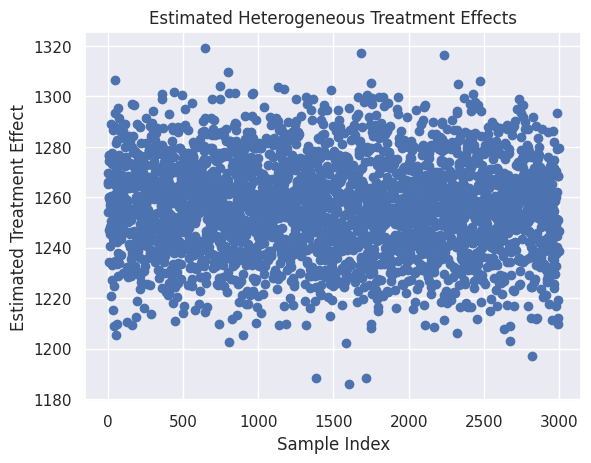

In [ ]:
plt.scatter(range(len(treatment_effects)), treatment_effects)
plt.xlabel('Sample Index')
plt.ylabel('Estimated Treatment Effect')
plt.title('Estimated Heterogeneous Treatment Effects')
plt.show()

### N: Inverse Propensity Weighting

Updated Inverse Propensity Weighting

In [ ]:
#runtime
import time
start_time = time.perf_counter()

In [ ]:
log_reg = LogisticRegression(max_iter=1000, solver='liblinear')
log_reg.fit(X, T)


propensity_scores = log_reg.predict_proba(X)[:, 1]

df['ps'] = propensity_scores

df['weights'] = np.where(df['T'] == 1, 1 / df['ps'], 1 / (1 - df['ps']))

In [ ]:
# Estimate the Weighted Outcome
weighted_treatment_outcome = np.sum(df[df['T'] == 1]['weights'] * df[df['T'] == 1]['Y']) / np.sum(df[df['T'] == 1]['weights'])
weighted_control_outcome = np.sum(df[df['T'] == 0]['weights'] * df[df['T'] == 0]['Y']) / np.sum(df[df['T'] == 0]['weights'])

In [ ]:
for _ in range(1000000):
    pass

end_time = time.perf_counter()

execution_time = end_time - start_time

print(f"The code took {execution_time} seconds to run.")

In [ ]:
# Average Treatment Effect (ATE) using IPW
ATE_ipw = weighted_treatment_outcome - weighted_control_outcome
print(f"Average Treatment Effect (ATE) using IPW: {ATE_ipw}")

### V: [Genetic Matching](https://ngreifer.github.io/blog/genetic-matching/)

library documentation: https://kosukeimai.github.io/MatchIt/reference/method_genetic.html

In [ ]:
import rpy2
import rpy2.robjects as robjects
from rpy2.robjects.packages import importr, data

from rpy2.robjects import r
from rpy2.robjects import pandas2ri
import rpy2.robjects as robjects
from rpy2.robjects.vectors import StrVector
pandas2ri.activate()

%load_ext rpy2.ipython

In [ ]:
%%R
#install.packages("MatchIt")
#install.packages("Matching")
#install.packages("rgenoud")

In [ ]:
%%R
library('MatchIt')
library('dplyr')
library('Matching')
library('rgenoud')

In [ ]:
cols = [f"X{i}" for i in range(150)]

In [ ]:
# Pass it to R
robjects.globalenv['df'] = pandas2ri.py2rpy(df)
robjects.globalenv['cols'] = StrVector(cols)

In [ ]:
%%R

# Create 'treat' variable from matching_df
treat <- df$T

# Subset covariates based on cols
covs <- df[, cols]

# Combine treat with covariates
df_for_ps <- cbind(treat, covs)

##### Start runtime

In [ ]:
import time

start_time = time.perf_counter()

In [ ]:
%%R

set.seed(0)
# Match for ATT (treated as focal group)
match_att <- matchit_out <- MatchIt::matchit(treat ~ .,data = df_for_ps,method = "genetic",estimand = "ATT",ratio = 1,replace = TRUE,
                                             pop.size = 200)
matched_att <- match.data(match_att)

Exception ignored from cffi callback <function _processevents at 0x7bd39d6082c0>:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/rpy2/rinterface_lib/callbacks.py", line 283, in _processevents
    @ffi_proxy.callback(ffi_proxy._processevents_def,
    
KeyboardInterrupt: 
Exception ignored from cffi callback <function _processevents at 0x7bd39d6082c0>:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/rpy2/rinterface_lib/callbacks.py", line 283, in _processevents
    @ffi_proxy.callback(ffi_proxy._processevents_def,
    
KeyboardInterrupt: 


In [ ]:
%%R

matched_att$Y <- df$Y[match(rownames(matched_att), rownames(df))]
matched_att$T <- df$T[match(rownames(matched_att), rownames(df))]

model_att <- lm(Y ~ T, data = matched_att, weights = weights)
att_est <- coef(model_att)["T"]

In [ ]:
%%R

# Match for ATC (controls as focal group)
match_atc <- matchit_out <- MatchIt::matchit(treat ~ .,data = df_for_ps,method = "genetic",estimand = "ATC",ratio = 1,replace = TRUE,
                                             pop.size = 200)
matched_atc <- match.data(match_atc)

In [ ]:
%%R

matched_atc$Y <- df$Y[match(rownames(matched_atc), rownames(df))]
matched_atc$T <- df$T[match(rownames(matched_atc), rownames(df))]

model_atc <- lm(Y ~ T, data = matched_atc, weights = weights)
atc_est <- coef(model_atc)["T"]

##### End runtime and find ATE

In [ ]:
for _ in range(1000000):
    pass

end_time = time.perf_counter()

execution_time = end_time - start_time

print(f"The code took {execution_time} seconds to run.")

In [ ]:
%%R

# Average them for ATE
ate_est <- (att_est + atc_est) / 2
ate_est

       T 
2822.731 


### Adaptive Hyperboxes

In [ ]:
cols_matching = [f"X{i}" for i in range(150)]

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

def fast_ahb(df, outcome_var, treatment_var, covariates, min_control=5, train_size=0.7,
             expansion_threshold=0.1, random_state=42):
    """
    Fast Adaptive Hyper-Box matching implementation

    Parameters:
    -----------
    df : pandas DataFrame
        The dataset
    outcome_var : str
        Name of the outcome variable
    treatment_var : str
        Name of the treatment variable
    covariates : list
        List of covariate names
    min_control : int
        Minimum number of control units required in each box
    train_size : float
        Proportion of data to use for training the outcome model
    expansion_threshold : float
        Threshold for stopping box expansion when outcome variability increases
    random_state : int
        Random seed for reproducibility

    Returns:
    --------
    dict : Dictionary containing boxes for each test unit and treatment effect estimates
    """

    X = df[covariates]
    y = df[outcome_var]
    T = df[treatment_var]

    X_train, X_test, y_train, y_test, T_train, T_test = train_test_split(
        X, y, T, train_size=train_size, random_state=random_state, stratify=T)


    rf_control = RandomForestRegressor(n_estimators=100, random_state=random_state)
    rf_treated = RandomForestRegressor(n_estimators=100, random_state=random_state)

    rf_control.fit(X_train[T_train == 0][covariates], y_train[T_train == 0])
    rf_treated.fit(X_train[T_train == 1][covariates], y_train[T_train == 1])


    f0_pred = rf_control.predict(X_test[covariates])
    f1_pred = rf_treated.predict(X_test[covariates])


    test_units = X_test.reset_index(drop=True)
    test_treatments = T_test.reset_index(drop=True)
    boxes = []
    matched_groups = []
    ite_estimates = []

    for i in range(len(test_units)):
        unit_i = test_units.iloc[i]
        treatment_i = test_treatments.iloc[i]


        box = {col: [unit_i[col], unit_i[col]] for col in covariates}


        prev_var = 0
        while True:

            in_box = is_in_box(test_units, box)
            units_in_box = test_units[in_box]
            treatments_in_box = test_treatments[in_box]


            n_control = sum(treatments_in_box == 0)
            if n_control >= min_control:

                control_pred = rf_control.predict(units_in_box[covariates])
                treated_pred = rf_treated.predict(units_in_box[covariates])

                current_var = (np.var(control_pred) + np.var(treated_pred)) / 2


                if current_var > prev_var * (1 + expansion_threshold) and n_control >= min_control:
                    break

                prev_var = current_var


            best_dim = None
            best_direction = None
            best_var_increase = float('inf')

            for dim in covariates:

                if any(test_units[dim] < box[dim][0]):
                    next_val = test_units[test_units[dim] < box[dim][0]][dim].max()
                    box_expansion = box.copy()
                    box_expansion[dim] = [next_val, box[dim][1]]


                    new_in_box = is_in_box(test_units, box_expansion)
                    new_units = test_units[new_in_box & ~in_box]

                    if len(new_units) > 0:
                        new_control_pred = rf_control.predict(new_units[covariates])
                        new_treated_pred = rf_treated.predict(new_units[covariates])

                        var_increase = (np.var(new_control_pred) + np.var(new_treated_pred)) / 2

                        if var_increase < best_var_increase:
                            best_var_increase = var_increase
                            best_dim = dim
                            best_direction = 'down'


                if any(test_units[dim] > box[dim][1]):
                    next_val = test_units[test_units[dim] > box[dim][1]][dim].min()
                    box_expansion = box.copy()
                    box_expansion[dim] = [box[dim][0], next_val]


                    new_in_box = is_in_box(test_units, box_expansion)
                    new_units = test_units[new_in_box & ~in_box]

                    if len(new_units) > 0:
                        new_control_pred = rf_control.predict(new_units[covariates])
                        new_treated_pred = rf_treated.predict(new_units[covariates])

                        var_increase = (np.var(new_control_pred) + np.var(new_treated_pred)) / 2

                        if var_increase < best_var_increase:
                            best_var_increase = var_increase
                            best_dim = dim
                            best_direction = 'up'


            if best_dim is None:
                break


            if best_direction == 'down':
                next_val = test_units[test_units[best_dim] < box[best_dim][0]][best_dim].max()
                box[best_dim][0] = next_val
            else:
                next_val = test_units[test_units[best_dim] > box[best_dim][1]][best_dim].min()
                box[best_dim][1] = next_val


            in_box = is_in_box(test_units, box)
            n_control = sum(test_treatments[in_box] == 0)
            if n_control >= min_control and best_var_increase > expansion_threshold * prev_var:
                break


        boxes.append(box)


        final_in_box = is_in_box(test_units, box)
        matched_group = test_units[final_in_box].index.tolist()
        matched_groups.append(matched_group)


        if treatment_i == 1:

            y_obs = y_test.iloc[i]
            control_units = test_units[final_in_box & (test_treatments == 0)]
            if len(control_units) > 0:
                y_cf = np.mean(y_test[control_units.index])
                ite = y_obs - y_cf
            else:
                ite = None
        else:

            y_obs = y_test.iloc[i]
            treated_units = test_units[final_in_box & (test_treatments == 1)]
            if len(treated_units) > 0:
                y_cf = np.mean(y_test[treated_units.index])
                ite = y_cf - y_obs
            else:
                ite = None

        ite_estimates.append(ite)

    # Return results
    results = {
        'boxes': boxes,
        'matched_groups': matched_groups,
        'ite_estimates': ite_estimates,
        'test_indices': X_test.index.tolist(),
        'test_treatments': T_test.tolist()
    }

    return results

def is_in_box(df, box):
    """
    Check which units are in a hyperbox

    Parameters:
    -----------
    df : pandas DataFrame
        DataFrame containing units
    box : dict
        Dictionary with column names as keys and [min, max] as values

    Returns:
    --------
    pandas Series : Boolean series indicating which units are in the box
    """
    in_box = pd.Series([True] * len(df), index=df.index)

    for col, (min_val, max_val) in box.items():
        in_box = in_box & (df[col] >= min_val) & (df[col] <= max_val)

    return in_box


def run_fast_ahb_analysis(df):

    outcome_var = 'murders'
    treatment_var = 'treatment'

    covariates = [col for col in cols_matching if col != 'treatment']

    # Fast AHB
    results = fast_ahb(
        df=df,
        outcome_var=outcome_var,
        treatment_var=treatment_var,
        covariates=covariates,
        min_control=3,
        expansion_threshold=0.1,
        random_state=42
    )

    # Calculate ATT
    treated_indices = [i for i, t in enumerate(results['test_treatments']) if t == 1]
    treated_ites = [results['ite_estimates'][i] for i in treated_indices if results['ite_estimates'][i] is not None]

    att = np.mean(treated_ites) if treated_ites else None

    print(f"Estimated ATT: {att}")

    return results, att

In [3]:
graphs = pd.read_excel('ATE.xlsx')
graphs

,Samples,Features,True ATE,PSM ATE,MALTS ATE,LCM ATE,Causal Forest ATE,IPW ATE,GenMatch ATE
0,1000,50,322.89,320.407488,321.19041,334.591649,314.702710,323.033430,322.002
1,1000,75,699.84,695.571300,696.80330,696.197440,697.169600,698.904850,704.303
2,1000,100,1270.89,1253.500000,1278.57000,1285.190000,1236.590000,1273.080000,1276.410
3,1000,125,2016.29,2035.250000,2011.61000,2051.540000,1971.270000,2014.400000,2017.890
4,1000,150,2844.21,2805.710000,2854.09000,2875.860000,2766.670000,2842.500000,2822.730
5,5000,50,322.12,320.560000,NaN,323.608520,314.950000,322.140000,NaN
6,5000,75,701.04,696.060000,NaN,706.303902,684.560000,700.810000,NaN
7,5000,100,1274.67,1266.460000,NaN,1259.520000,1247.570000,1275.040000,NaN
8,5000,125,1953.64,1953.010000,NaN,1948.820000,1922.810000,1953.490000,NaN
9,5000,150,2855.75,2845.250000,NaN,2847.790000,2812.930000,2855.540000,NaN


In [4]:
# Filter for 1000 samples only
df_1000 = graphs[graphs["Samples"] == 1000].copy()


,Samples,Features,True ATE,PSM ATE,MALTS ATE,LCM ATE,Causal Forest ATE,IPW ATE,GenMatch ATE
0,1000,50,322.89,320.407488,321.19041,334.591649,314.70271,323.03343,322.002
1,1000,75,699.84,695.571300,696.80330,696.197440,697.16960,698.90485,704.303
2,1000,100,1270.89,1253.500000,1278.57000,1285.190000,1236.59000,1273.08000,1276.410
3,1000,125,2016.29,2035.250000,2011.61000,2051.540000,1971.27000,2014.40000,2017.890
4,1000,150,2844.21,2805.710000,2854.09000,2875.860000,2766.67000,2842.50000,2822.730


In [30]:
df_5000 = graphs[graphs["Samples"] == 5000].copy()
df_10000 = graphs[graphs["Samples"] == 10000].copy()
df_100000 = graphs[graphs["Samples"] == 100000].copy()

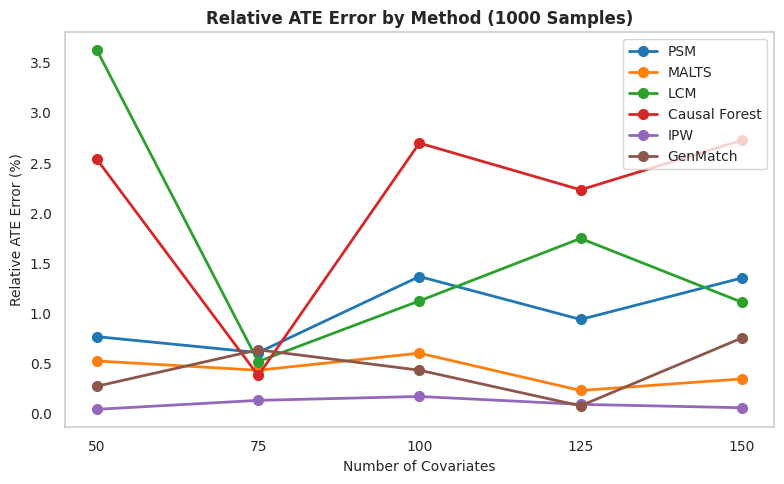

In [29]:
methods = ["PSM ATE", "MALTS ATE", "LCM ATE", "Causal Forest ATE", "IPW ATE", "GenMatch ATE"]

for method in methods:
    df_1000[method + " Error (%)"] = abs(df_1000[method] - df_1000["True ATE"]) / df_1000["True ATE"] * 100


plt.figure(figsize=(8, 5))
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown']
markers = ['o', 'o', 'o', 'o', 'o', 'o']

for method, color, marker in zip(methods, colors, markers):
    plt.plot(
        df_1000["Features"],
        df_1000[method + " Error (%)"],
        marker=marker,
        label=method.replace(" ATE", ''),
        color=color,
        linewidth=2
    )

plt.title(
    "Relative ATE Error by Method (1000 Samples)",
    fontsize=12,
    fontweight='bold',

)

plt.xlabel(
    "Number of Covariates",
    fontsize=10
)

plt.ylabel(
    "Relative ATE Error (%)",
    fontsize=10
)



ax = plt.gca()
ax.set_xticks([50, 75, 100, 125, 150])
ax.tick_params(axis='both', labelsize=10)
ax.grid(False)


plt.legend(fontsize=10, title_fontsize=11, loc="best", frameon=True)

plt.tight_layout()
plt.show()


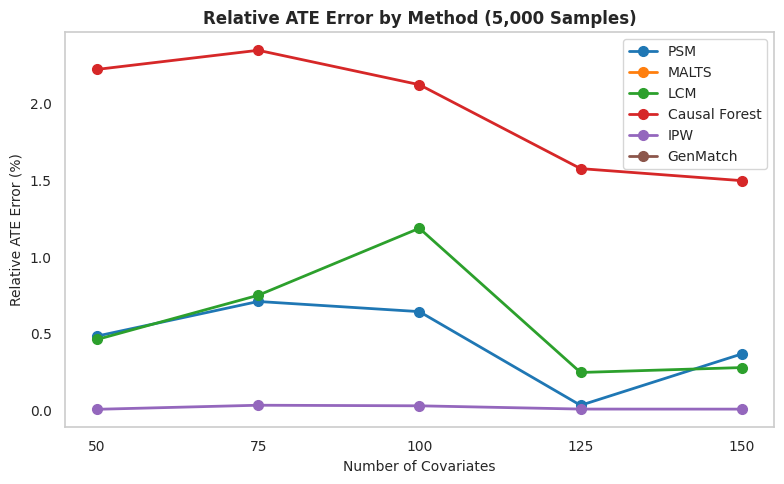

In [33]:
#methods = ["PSM ATE", "MALTS ATE", "LCM ATE", "Causal Forest ATE", "IPW ATE", "GenMatch ATE"]

for method in methods:
    df_5000[method + " Error (%)"] = abs(df_5000[method] - df_5000["True ATE"]) / df_5000["True ATE"] * 100


plt.figure(figsize=(8, 5))
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown']
markers = ['o', 'o', 'o', 'o', 'o', 'o']

for method, color, marker in zip(methods, colors, markers):
    plt.plot(
        df_5000["Features"],
        df_5000[method + " Error (%)"],
        marker=marker,
        label=method.replace(" ATE", ''),
        color=color,
        linewidth=2
    )

plt.title( "Relative ATE Error by Method (5,000 Samples)", fontsize=12, fontweight='bold')
plt.xlabel("Number of Covariates", fontsize=10)
plt.ylabel("Relative ATE Error (%)",fontsize=10)

ax = plt.gca()
ax.set_xticks([50, 75, 100, 125, 150])
ax.tick_params(axis='both', labelsize=10)
ax.grid(False)


plt.legend(fontsize=10, title_fontsize=11, loc="best", frameon=True)

plt.tight_layout()
plt.show()


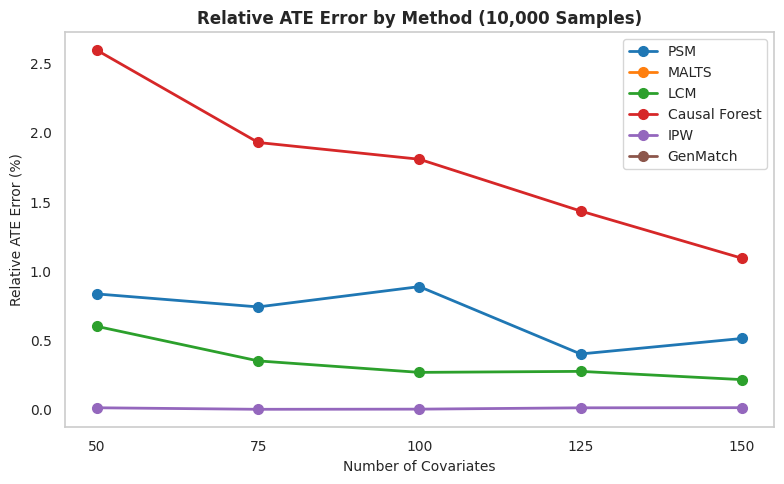

In [34]:
#methods = ["PSM ATE", "MALTS ATE", "LCM ATE", "Causal Forest ATE", "IPW ATE", "GenMatch ATE"]

for method in methods:
    df_10000[method + " Error (%)"] = abs(df_10000[method] - df_10000["True ATE"]) / df_10000["True ATE"] * 100


plt.figure(figsize=(8, 5))
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown']
markers = ['o', 'o', 'o', 'o', 'o', 'o']

for method, color, marker in zip(methods, colors, markers):
    plt.plot(
        df_10000["Features"],
        df_10000[method + " Error (%)"],
        marker=marker,
        label=method.replace(" ATE", ''),
        color=color,
        linewidth=2
    )

plt.title( "Relative ATE Error by Method (10,000 Samples)", fontsize=12, fontweight='bold')
plt.xlabel("Number of Covariates", fontsize=10)
plt.ylabel("Relative ATE Error (%)",fontsize=10)

ax = plt.gca()
ax.set_xticks([50, 75, 100, 125, 150])
ax.tick_params(axis='both', labelsize=10)
ax.grid(False)


plt.legend(fontsize=10, title_fontsize=11, loc="best", frameon=True)

plt.tight_layout()
plt.show()


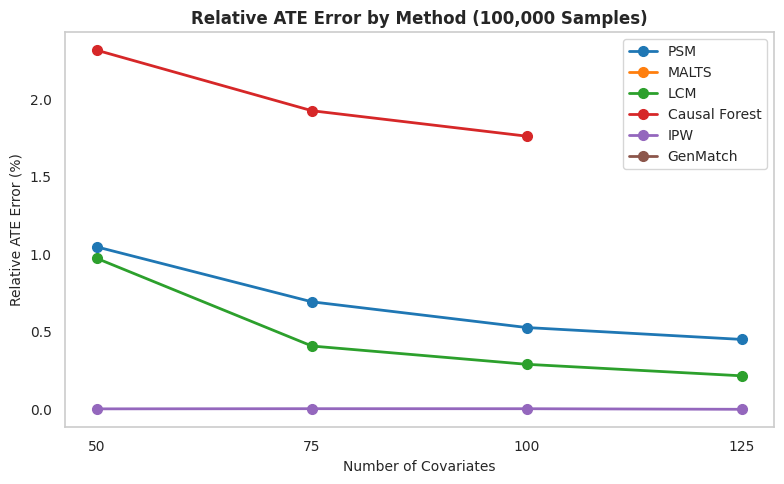

In [36]:
#methods = ["PSM ATE", "MALTS ATE", "LCM ATE", "Causal Forest ATE", "IPW ATE", "GenMatch ATE"]

for method in methods:
    df_100000[method + " Error (%)"] = abs(df_100000[method] - df_100000["True ATE"]) / df_100000["True ATE"] * 100


plt.figure(figsize=(8, 5))
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown']
markers = ['o', 'o', 'o', 'o', 'o', 'o']

for method, color, marker in zip(methods, colors, markers):
    plt.plot(
        df_100000["Features"],
        df_100000[method + " Error (%)"],
        marker=marker,
        label=method.replace(" ATE", ''),
        color=color,
        linewidth=2
    )

plt.title( "Relative ATE Error by Method (100,000 Samples)", fontsize=12, fontweight='bold')
plt.xlabel("Number of Covariates", fontsize=10)
plt.ylabel("Relative ATE Error (%)",fontsize=10)

ax = plt.gca()
ax.set_xticks([50, 75, 100, 125])
ax.tick_params(axis='both', labelsize=10)
ax.grid(False)


plt.legend(fontsize=10, title_fontsize=11, loc="best", frameon=True)

plt.tight_layout()
plt.show()